# Click-Through Rate Prediction
### We use data of mobile ads to predict click-through rate
### data source: https://www.kaggle.com/c/avazu-ctr-prediction
### Author: Beibei (Ben) Wang

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

import numpy as np
np.random.seed(0)
import random
random.seed(0)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

### Sample 4 million data points from the original ~6G dataset:

In [3]:
n_train = 40428967  # total number of records in the training set
n_sample = 4000000
skipped_rows = sorted(random.sample(range(1, n_train), n_train - n_sample))

## define data type for training and test sets:
types_train = {
    'id': np.dtype(int), 'click': np.dtype(int), 'hour': np.dtype(int), 'C1': np.dtype(int),
    'banner_pos': np.dtype(int),'site_id': np.dtype(str), 'site_domain': np.dtype(str),
    'site_category': np.dtype(str), 'app_id': np.dtype(str), 'app_domain': np.dtype(str),
    'app_category': np.dtype(str), 'device_id': np.dtype(str), 'device_ip': np.dtype(str),
    'device_model': np.dtype(str), 'device_type': np.dtype(int), 'device_conn_type': np.dtype(int),
    'C14': np.dtype(int), 'C15': np.dtype(int), 'C16': np.dtype(int), 'C17': np.dtype(int), 
    'C18': np.dtype(int), 'C19': np.dtype(int), 'C20': np.dtype(int), 'C21':np.dtype(int)
}

types_test = { key:val for (key,val) in types_train.items() if key!= 'click'}

### Load data:

In [4]:
import gzip

get_date = lambda s : pd.datetime.strptime(s, '%y%m%d%H')

with gzip.open('./data/CTR_train.gz') as f:
    train_df = pd.read_csv(f, parse_dates = ['hour'], date_parser = get_date,
                         dtype = types_train, skiprows = skipped_rows)

In [5]:
train_df.drop('id', axis=1, inplace=True)
train_df.head(2)

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,15706,320,50,1722,0,35,-1,79
1,0,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,...,1,0,20362,320,50,2333,0,39,-1,157


In [6]:
#train_df.dtypes

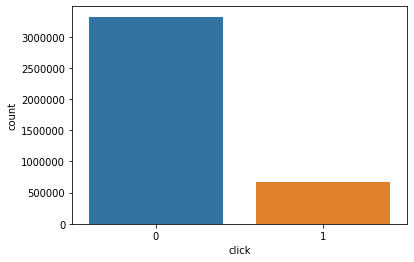

In [7]:
sns.countplot(x='click',data=train_df)
plt.show()

In [8]:
print(train_df['click'].value_counts())
print(train_df['click'].value_counts()/len(train_df))

0    3322447
1     677553
Name: click, dtype: int64
0    0.830612
1    0.169388
Name: click, dtype: float64


###  Balance the number of samples for click == 0 and click == 1 ??

In [9]:
#rate = 1697981.0/8302019.0
#print(f"Ratio between sample counts of click = 1 and click = 0: {rate}")

#def myFilter(row, rate):
#    if row.click == 1:
#        return True
#    else:
#        trial = random.random()
#        if trial < rate:
#            return True
#    return False

In [10]:
#train_df = train_df[train_df.apply(lambda r: myFilter(r, rate), axis=1)]
#TotalSize = len(train_df)
#print(f"How many samples now? {TotalSize}")
##train_df = train_df.sample(n = 2000000) 

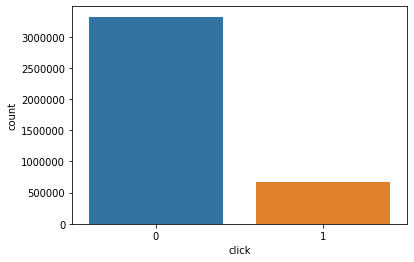

In [11]:
sns.countplot(x='click',data=train_df)
plt.show()

### Now we can work on the new train_df, since the number of click=0 & 1 sample are the same

Text(0.5, 1.0, 'Number of clicks by hour')

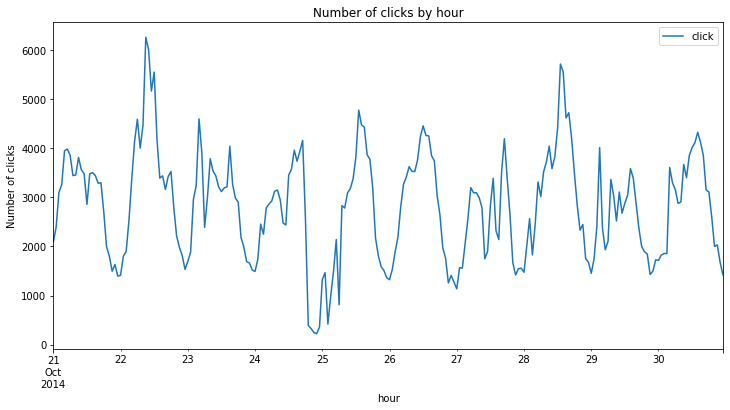

In [12]:
#sns.countplot(x='int_hour',data=train_df)
train_df.groupby('hour').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour')

In [13]:
#train_df.dtypes

In [14]:
## add features: 'hour_of_day' and 'day_of_week'
train_df['hour_of_day'] = train_df['hour'].apply(lambda t: t.hour)
train_df['day_of_week'] = train_df['hour'].apply(lambda t: t.weekday_name)

Text(0.5, 1.0, 'Clicks on hourly impressions vs. clicks')

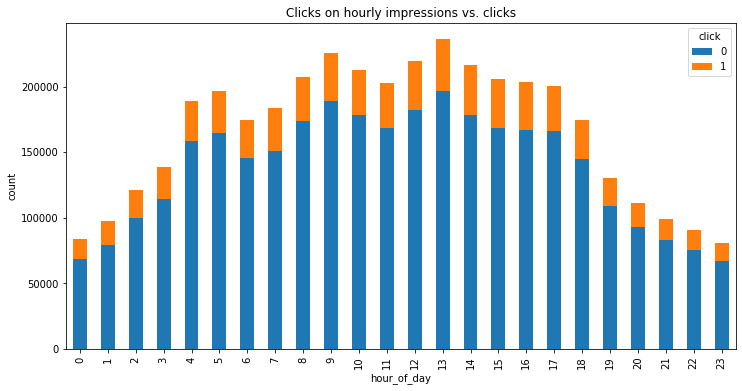

In [15]:
train_df.groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar',
                                                                 stacked=True,
                                                                 title="Hour of the Day",
                                                                 figsize=(12,6))

#train_df.groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar',stacked=True, title="Hour of the Day", figsize=(12,6))

plt.ylabel('count')
plt.title('Clicks on hourly impressions vs. clicks')

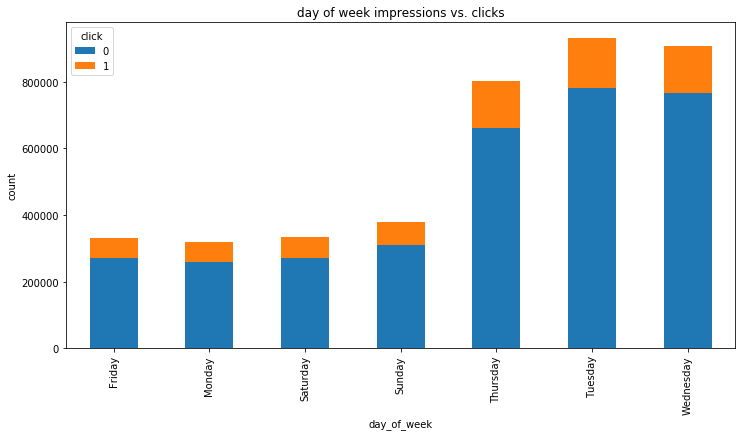

In [16]:
train_df.groupby(['day_of_week', 'click']).size().unstack().plot(kind='bar',
                                                                 stacked=True, 
                                                                 title="Day of the week",
                                                                 figsize=(12,6))

#train_df.groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar',stacked=True, title="Hour of the Day", figsize=(12,6))

plt.ylabel('count')
plt.title('day of week impressions vs. clicks');

Text(0.5, 0, 'C1 domain')

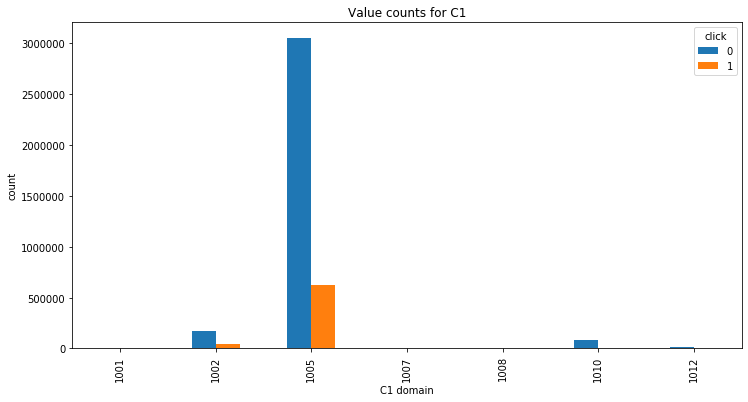

In [17]:
train_df.groupby(['C1', 'click']).size().unstack().plot(kind='bar', title="Value counts for C1", figsize=(12,6))
plt.ylabel('count')
plt.xlabel('C1 domain')

Text(0.5, 0, 'banner_pos')

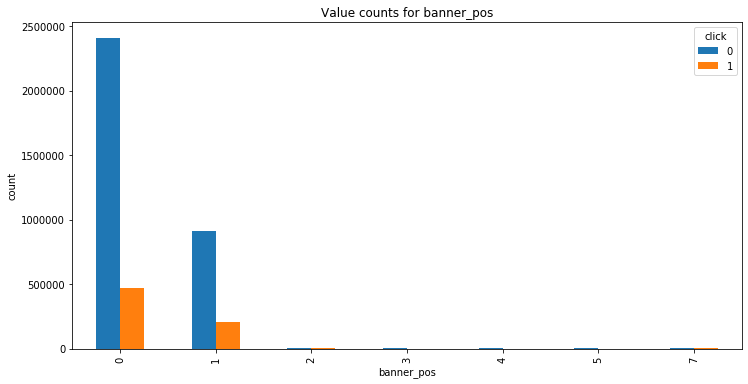

In [18]:
train_df.groupby(['banner_pos', 'click']).size().unstack().plot(kind='bar', title="Value counts for banner_pos", figsize=(12,6))
plt.ylabel('count')
plt.xlabel('banner_pos')

Text(0.5, 0, 'site_category')

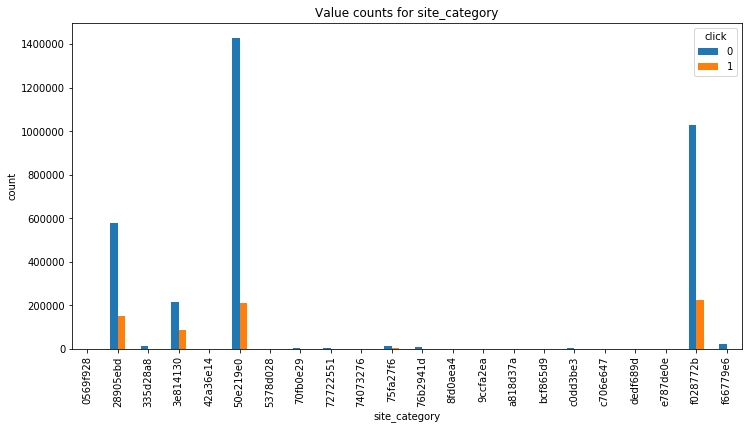

In [19]:
train_df.groupby(['site_category', 'click']).size().unstack().plot(kind='bar',
                                                                   title="Value counts for site_category",
                                                                   figsize=(12,6))
plt.ylabel('count')
plt.xlabel('site_category')

Text(0.5, 0, 'app_category')

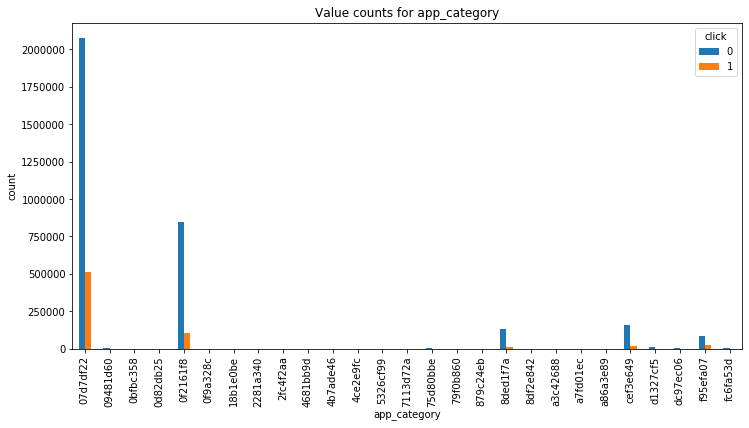

In [20]:
train_df.groupby(['app_category', 'click']).size().unstack().plot(kind='bar',
                                                                  title="Value counts for app_category",
                                                                  figsize=(12,6))
plt.ylabel('count')
plt.xlabel('app_category')

Text(0.5, 0, 'device_type')

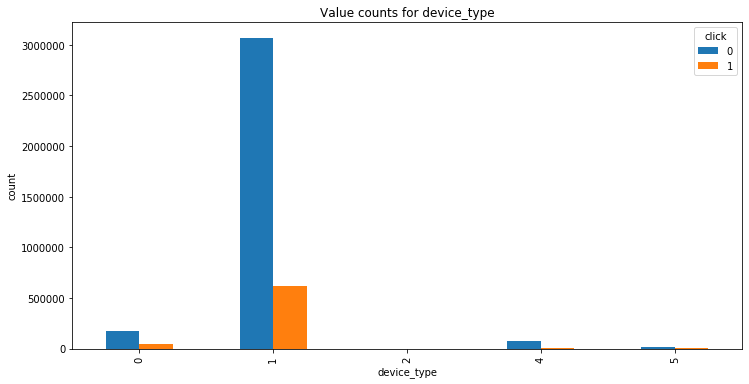

In [21]:
train_df.groupby(['device_type', 'click']).size().unstack().plot(kind='bar',
                                                                 title="Value counts for device_type",
                                                                 figsize=(12,6))
plt.ylabel('count')
plt.xlabel('device_type')

In [22]:
#train_df.groupby(['device_id', 'click']).size().unstack().plot(kind='bar', stacked=True, title="Value counts for device_id", figsize=(12,6))
#plt.ylabel('count')
#plt.xlabel('device_id')

In [23]:
#train_df.groupby(['device_ip', 'click']).size().unstack().plot(kind='bar', stacked=True, title="Value counts for device_ip", figsize=(12,6))
#plt.ylabel('count')
#plt.xlabel('device_ip')

Text(0.5, 0, 'device_conn_type')

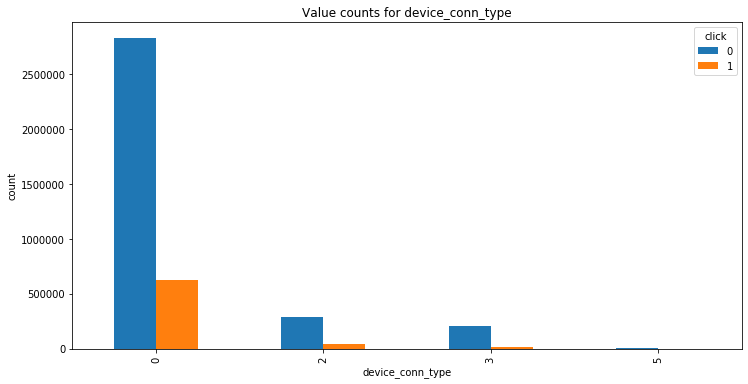

In [24]:
train_df.groupby(['device_conn_type', 'click']).size().unstack().plot(kind='bar',
                                                                      title="Value counts for device_conn_type",
                                                                      figsize=(12,6))
plt.ylabel('count')
plt.xlabel('device_conn_type')

C15
C16


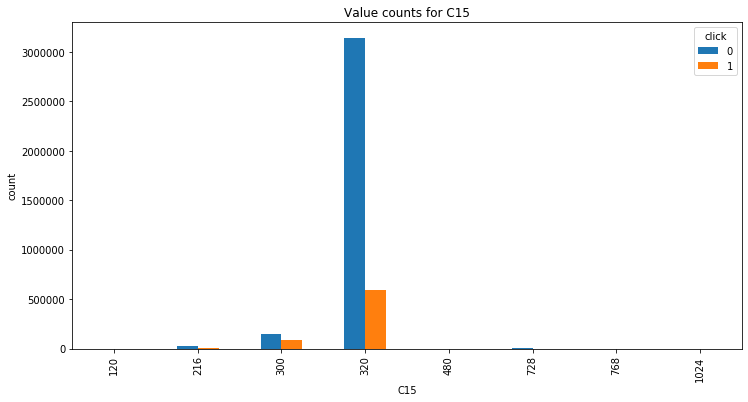

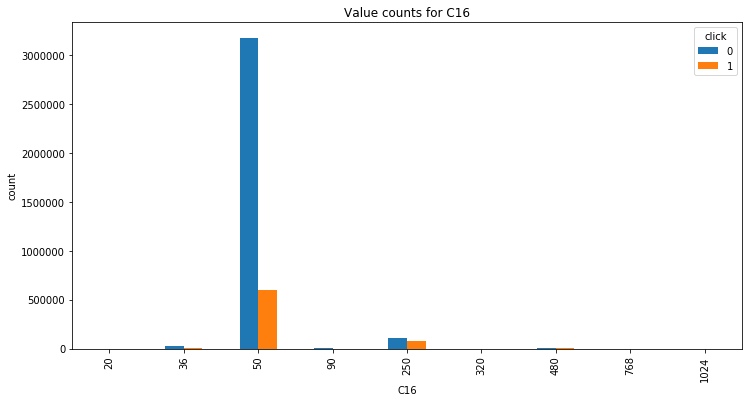

In [25]:
features = ['C15', 'C16']
for feature in features:
    print(feature)
    train_df.groupby([feature, 'click']).size().unstack().plot(kind='bar',
                                                               title='Value counts for '+feature,
                                                               figsize=(12,6))
    plt.ylabel("count")
    plt.xlabel(feature)

C18
C19
C21


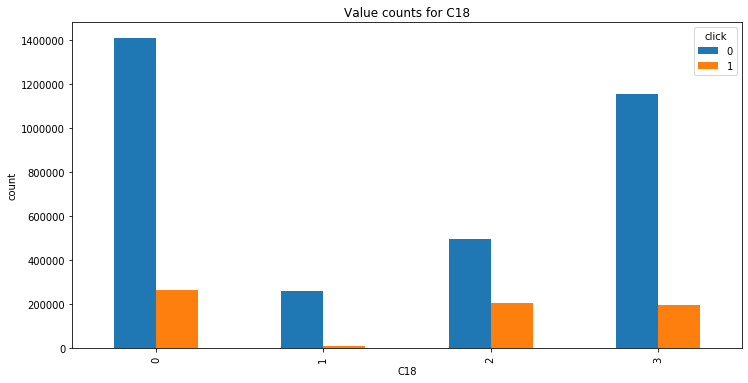

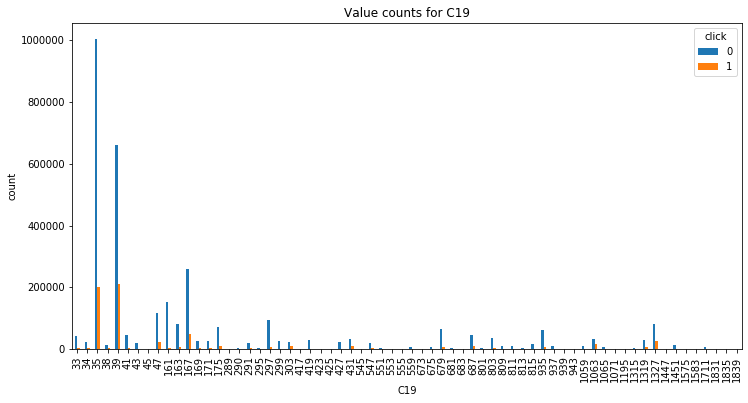

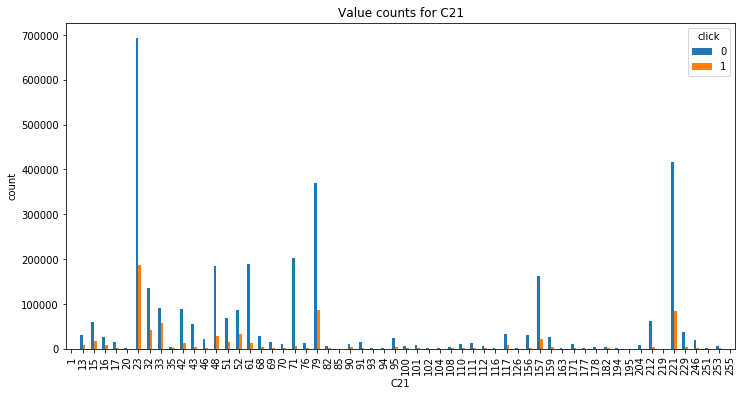

In [26]:
features = ['C18', 'C19', 'C21']
for feature in features:
    print(feature)
    train_df.groupby([feature, 'click']).size().unstack().plot(kind='bar',
                                                               title='Value counts for '+feature,
                                                               figsize=(12,6))
    plt.ylabel("count")
    plt.xlabel(feature)

In [27]:
#train_df.drop('id', axis=1, inplace=True)
train_df.drop('hour', axis=1, inplace=True)

columns = list(train_df.columns)

for c in columns:
    #print("For column " + c + ", number of unique value: ", train_df[c].value_counts())
    print("For column " + c + ", number of unique value: ", train_df[c].nunique())

For column click, number of unique value:  2
For column C1, number of unique value:  7
For column banner_pos, number of unique value:  7
For column site_id, number of unique value:  3434
For column site_domain, number of unique value:  4233
For column site_category, number of unique value:  22
For column app_id, number of unique value:  4866
For column app_domain, number of unique value:  305
For column app_category, number of unique value:  27
For column device_id, number of unique value:  499639
For column device_ip, number of unique value:  1622197
For column device_model, number of unique value:  6353
For column device_type, number of unique value:  5
For column device_conn_type, number of unique value:  4
For column C14, number of unique value:  2455
For column C15, number of unique value:  8
For column C16, number of unique value:  9
For column C17, number of unique value:  426
For column C18, number of unique value:  4
For column C19, number of unique value:  66
For column C20, 

### Check CTR for some features

In [42]:
def featureCTR(train_df, feature):
    values = train_df[feature].unique()
    values.sort()
    for v in values:
        CTR_df = train_df.loc[np.where((train_df[feature]==v))].click
        CTR = CTR_df.mean()
        count = CTR_df.count()
        print(f"For {feature} = {v}, sample counts: {count}, CTR = {CTR}")

In [43]:
featureCTR(train_df, 'C1')

For C1 = 1001, sample counts: 919, CTR = 0.028291621327529923
For C1 = 1002, sample counts: 219060, CTR = 0.2120514927417146
For C1 = 1005, sample counts: 3675337, CTR = 0.1688032961331165
For C1 = 1007, sample counts: 3486, CTR = 0.04102122776821572
For C1 = 1008, sample counts: 555, CTR = 0.13513513513513514
For C1 = 1010, sample counts: 89497, CTR = 0.09565683765936288
For C1 = 1012, sample counts: 11146, CTR = 0.16929840301453436


In [44]:
featureCTR(train_df, 'banner_pos')

For banner_pos = 0, sample counts: 2880226, CTR = 0.16391630379004982
For banner_pos = 1, sample counts: 1112604, CTR = 0.18303457474537213
For banner_pos = 2, sample counts: 1234, CTR = 0.12155591572123177
For banner_pos = 3, sample counts: 208, CTR = 0.14423076923076922
For banner_pos = 4, sample counts: 748, CTR = 0.17647058823529413
For banner_pos = 5, sample counts: 555, CTR = 0.13513513513513514
For banner_pos = 7, sample counts: 4425, CTR = 0.31751412429378534


In [45]:
featureCTR(train_df, 'site_category')

For site_category = 0569f928, sample counts: 1772, CTR = 0.05191873589164785
For site_category = 28905ebd, sample counts: 729037, CTR = 0.20779740945932784
For site_category = 335d28a8, sample counts: 13675, CTR = 0.09206581352833638
For site_category = 3e814130, sample counts: 301872, CTR = 0.28163592516033287
For site_category = 42a36e14, sample counts: 264, CTR = 0.21212121212121213
For site_category = 50e219e0, sample counts: 1636727, CTR = 0.12857978147852392
For site_category = 5378d028, sample counts: 39, CTR = 0.1282051282051282
For site_category = 70fb0e29, sample counts: 2434, CTR = 0.1516023007395234
For site_category = 72722551, sample counts: 2840, CTR = 0.05563380281690141
For site_category = 74073276, sample counts: 1, CTR = 0.0
For site_category = 75fa27f6, sample counts: 16270, CTR = 0.11432083589428396
For site_category = 76b2941d, sample counts: 10318, CTR = 0.030626090327582865
For site_category = 8fd0aea4, sample counts: 713, CTR = 0.014025245441795231
For site_cat

In [46]:
featureCTR(train_df, 'app_category')

For app_category = 07d7df22, sample counts: 2587490, CTR = 0.19862028452283872
For app_category = 09481d60, sample counts: 5634, CTR = 0.15885694000709974
For app_category = 0bfbc358, sample counts: 35, CTR = 0.02857142857142857
For app_category = 0d82db25, sample counts: 4, CTR = 0.0
For app_category = 0f2161f8, sample counts: 946994, CTR = 0.10810205766879198
For app_category = 0f9a328c, sample counts: 582, CTR = 0.13917525773195877
For app_category = 18b1e0be, sample counts: 20, CTR = 0.1
For app_category = 2281a340, sample counts: 230, CTR = 0.02608695652173913
For app_category = 2fc4f2aa, sample counts: 27, CTR = 0.0
For app_category = 4681bb9d, sample counts: 561, CTR = 0.15151515151515152
For app_category = 4b7ade46, sample counts: 2, CTR = 0.0
For app_category = 4ce2e9fc, sample counts: 2021, CTR = 0.1271647699158832
For app_category = 5326cf99, sample counts: 17, CTR = 0.0
For app_category = 7113d72a, sample counts: 36, CTR = 0.0
For app_category = 75d80bbe, sample counts: 411

In [47]:
featureCTR(train_df, 'device_type')

For device_type = 0, sample counts: 219060, CTR = 0.2120514927417146
For device_type = 1, sample counts: 3691440, CTR = 0.16864421472379343
For device_type = 2, sample counts: 3, CTR = 0.0
For device_type = 4, sample counts: 76745, CTR = 0.09545898755619259
For device_type = 5, sample counts: 12752, CTR = 0.09684755332496864


In [48]:
featureCTR(train_df, 'device_conn_type')

For device_conn_type = 0, sample counts: 3451125, CTR = 0.180655293563693
For device_conn_type = 2, sample counts: 329047, CTR = 0.135084045744225
For device_conn_type = 3, sample counts: 215603, CTR = 0.044104210052735814
For device_conn_type = 5, sample counts: 4225, CTR = 0.031005917159763315


In [49]:
featureCTR(train_df, 'C15')

For C15 = 120, sample counts: 303, CTR = 0.0297029702970297
For C15 = 216, sample counts: 29551, CTR = 0.1287266082366079
For C15 = 300, sample counts: 230836, CTR = 0.35874820218683395
For C15 = 320, sample counts: 3731218, CTR = 0.1581982076630205
For C15 = 480, sample counts: 229, CTR = 0.3056768558951965
For C15 = 728, sample counts: 7425, CTR = 0.057373737373737375
For C15 = 768, sample counts: 171, CTR = 0.4444444444444444
For C15 = 1024, sample counts: 267, CTR = 0.3146067415730337


In [50]:
featureCTR(train_df, 'C16')

For C16 = 20, sample counts: 303, CTR = 0.0297029702970297
For C16 = 36, sample counts: 29551, CTR = 0.1287266082366079
For C16 = 50, sample counts: 3773174, CTR = 0.15793175718904032
For C16 = 90, sample counts: 7425, CTR = 0.057373737373737375
For C16 = 250, sample counts: 178528, CTR = 0.4201917906434845
For C16 = 320, sample counts: 229, CTR = 0.3056768558951965
For C16 = 480, sample counts: 10352, CTR = 0.2090417310664606
For C16 = 768, sample counts: 267, CTR = 0.3146067415730337
For C16 = 1024, sample counts: 171, CTR = 0.4444444444444444


In [51]:
featureCTR(train_df, 'C18')

For C18 = 0, sample counts: 1676109, CTR = 0.1577099102743318
For C18 = 1, sample counts: 269181, CTR = 0.033951133252346936
For C18 = 2, sample counts: 703675, CTR = 0.2943773759192809
For C18 = 3, sample counts: 1351035, CTR = 0.1457615827865303


In [52]:
featureCTR(train_df, 'hour_of_day')

For hour_of_day = 0, sample counts: 83524, CTR = 0.1809779225132896
For hour_of_day = 1, sample counts: 97443, CTR = 0.18454891577640262
For hour_of_day = 2, sample counts: 121000, CTR = 0.17436363636363636
For hour_of_day = 3, sample counts: 138569, CTR = 0.1747432686964617
For hour_of_day = 4, sample counts: 188815, CTR = 0.15896512459285544
For hour_of_day = 5, sample counts: 196704, CTR = 0.1628589149178461
For hour_of_day = 6, sample counts: 174568, CTR = 0.16818088080289628
For hour_of_day = 7, sample counts: 183650, CTR = 0.17892186223795262
For hour_of_day = 8, sample counts: 207355, CTR = 0.16306334547032866
For hour_of_day = 9, sample counts: 225289, CTR = 0.16054933884921146
For hour_of_day = 10, sample counts: 212599, CTR = 0.161101416281356
For hour_of_day = 11, sample counts: 202419, CTR = 0.1686600566152387
For hour_of_day = 12, sample counts: 219322, CTR = 0.17044801707079088
For hour_of_day = 13, sample counts: 236562, CTR = 0.1678545159408527
For hour_of_day = 14, sam

In [53]:
featureCTR(train_df, 'day_of_week')

For day_of_week = Friday, sample counts: 330042, CTR = 0.17438386629580477
For day_of_week = Monday, sample counts: 318471, CTR = 0.18312185410916534
For day_of_week = Saturday, sample counts: 332921, CTR = 0.1822234103586136
For day_of_week = Sunday, sample counts: 378935, CTR = 0.182070803699843
For day_of_week = Thursday, sample counts: 800708, CTR = 0.17457175399771202
For day_of_week = Tuesday, sample counts: 931714, CTR = 0.16135745518474554
For day_of_week = Wednesday, sample counts: 907209, CTR = 0.15641489447304865


In [54]:
## in the original 6G data, there are total 40428967 samples including:
## click == 1: 6865066
## click == 0: 33563901

In [66]:
## define funtion to check column 0-1 distribution:
#train_df.query("click == 0")['device_id'].value_counts()

def col_01_check(col_name):
    tmp_0 = train_df.query("click == 0")[col_name].value_counts()
    tmp_1 = train_df.query("click == 1")[col_name].value_counts()
    tmp_count = pd.concat([tmp_0, tmp_1], axis=1, sort=False)
    tmp_count.columns = [col_name+'_0_count', col_name+'_1_count']
    print(tmp_count)

In [67]:
col_01_check('site_id')

          site_id_0_count  site_id_1_count
85f751fd        1273857.0         171473.0
1fbe01fe         509854.0         131600.0
e151e245         183962.0          77094.0
856e6d3f          72364.0           3230.0
d9750ee7          68497.0          26690.0
...                   ...              ...
b612cdcb              NaN              1.0
706c4398              NaN              1.0
eb4792c5              NaN              1.0
7ff03653              NaN              1.0
e41fe8c5              NaN              1.0

[3434 rows x 2 columns]


In [68]:
col_01_check('site_domain')

          site_domain_0_count  site_domain_1_count
c4e18dd6            1314412.0             183761.0
f3845767             509854.0             131600.0
7e091613             244462.0              84611.0
16a36ef3              72727.0              12043.0
58a89a43              72364.0               3230.0
...                       ...                  ...
136e13ef                  NaN                  1.0
f126f9ba                  NaN                  1.0
097f95af                  NaN                  1.0
5c95df40                  NaN                  1.0
6d0b83b8                  NaN                  1.0

[4233 rows x 2 columns]


In [69]:
col_01_check('site_category')

          site_category_0_count  site_category_1_count
50e219e0                1426277               210450.0
f028772b                1028193               223810.0
28905ebd                 577545               151492.0
3e814130                 216854                85018.0
f66779e6                  23829                  980.0
75fa27f6                  14410                 1860.0
335d28a8                  12416                 1259.0
76b2941d                  10002                  316.0
c0dd3be3                   3749                  454.0
72722551                   2682                  158.0
70fb0e29                   2065                  369.0
0569f928                   1680                   92.0
dedf689d                   1231                 1209.0
8fd0aea4                    703                   10.0
a818d37a                    322                    3.0
42a36e14                    208                   56.0
e787de0e                    110                   10.0
bcf865d9  

In [70]:
col_01_check('app_id')

          app_id_0_count  app_id_1_count
ecad2386       2048590.0        506080.0
92f5800b        151023.0          2952.0
e2fcccd2         89966.0         21769.0
febd1138         71688.0          3663.0
9c13b419         51962.0         22909.0
...                  ...             ...
ee1b70ac             NaN             1.0
025f3b9b             NaN             1.0
2e4d5ff3             NaN             1.0
3d7881ec             NaN             1.0
79c16aec             NaN             1.0

[4866 rows x 2 columns]


In [71]:
col_01_check('app_domain')

          app_domain_0_count  app_domain_1_count
7801e8d9           2169913.0            523564.0
2347f47a            447389.0             71555.0
ae637522            181672.0              4440.0
5c5a694b             89984.0             21771.0
82e27996             71692.0              3663.0
...                      ...                 ...
e9616877                 NaN                 1.0
6cf43c3b                 NaN                 1.0
b4df0cc5                 NaN                 1.0
f2140094                 NaN                 1.0
9c875c2e                 NaN                 1.0

[305 rows x 2 columns]


In [72]:
col_01_check('app_category')

          app_category_0_count  app_category_1_count
07d7df22               2073562              513928.0
0f2161f8                844622              102372.0
cef3e649                155421               15936.0
8ded1f7a                131971               12999.0
f95efa07                 85034               27937.0
d1327cf5                 10863                1507.0
09481d60                  4739                 895.0
dc97ec06                  4574                 781.0
75d80bbe                  3729                 387.0
fc6fa53d                  2188                 124.0
4ce2e9fc                  1764                 257.0
879c24eb                  1162                 133.0
a3c42688                  1041                  56.0
0f9a328c                   501                  81.0
4681bb9d                   476                  85.0
2281a340                   224                   6.0
a86a3e89                   223                  31.0
8df2e842                   134                

In [73]:
col_01_check('device_id')

          device_id_0_count  device_id_1_count
a99f214a          2728170.0           572845.0
936e92fb             1272.0               88.0
c357dbff              769.0             1260.0
afeffc18              705.0              247.0
0f7c61dc              524.0             1608.0
...                     ...                ...
f25af616                NaN                1.0
e6276451                NaN                1.0
390aecd5                NaN                1.0
f164e0e8                NaN                1.0
ea777e31                NaN                1.0

[499639 rows x 2 columns]


In [74]:
col_01_check('device_ip')

          device_ip_0_count  device_ip_1_count
6b9769f2            15882.0             4668.0
431b3174            10785.0             2576.0
2f323f36             8043.0              870.0
af9205f9             7879.0              800.0
af62faf4             7819.0              804.0
...                     ...                ...
dc21a53a                NaN                1.0
f5b2e177                NaN                1.0
b584c0ee                NaN                1.0
d9f6cbbd                NaN                1.0
dd26a10c                NaN                1.0

[1622197 rows x 2 columns]


In [75]:
def hash_columns(self):
    
    list_columns = self.columns
    new_col_suffix = '_int'
    for i in range(0,len(list_columns)):
        if list_columns[i] == 'click': continue
        self[list_columns[i]+new_col_suffix] = self[list_columns[i]].map( lambda  x: hash(str(x)) )
        self.drop([list_columns[i]],inplace=True,axis=1)
    return self

In [76]:
train_df = hash_columns(train_df)

In [77]:
train_df = train_df.reset_index(drop=True)
train_df.head(5)

,click,C1_int,banner_pos_int,site_id_int,site_domain_int,site_category_int,app_id_int,app_domain_int,app_category_int,device_id_int,...,C14_int,C15_int,C16_int,C17_int,C18_int,C19_int,C20_int,C21_int,hour_of_day_int,day_of_week_int
0,0,-8408628050835440652,-5417431257874455812,1673322264058022261,4136150990272089516,-4538055098461420119,3320678617334553521,2642023076892718409,-5011087804400385012,2848956435762274756,...,1878153806018099954,-3932806785507200144,6972974030339039815,-7731559908746589179,-5417431257874455812,9151626688618292953,-621229269874291962,7512058234280129433,-5417431257874455812,-1939954985844146708
1,0,-8408628050835440652,-5417431257874455812,3985989825703782288,-5392433511070588970,2331532187069926637,3320678617334553521,2642023076892718409,-5011087804400385012,2848956435762274756,...,6704963071632075256,-3932806785507200144,6972974030339039815,-5920984929367109130,-5417431257874455812,-676103175383297147,-621229269874291962,-3248888030376266360,-5417431257874455812,-1939954985844146708
2,0,-8408628050835440652,1658569078973979185,251520864115883640,-1759778825659884517,-861564286970769635,3320678617334553521,2642023076892718409,-5011087804400385012,2848956435762274756,...,-4431038327051514268,-3932806785507200144,6972974030339039815,4279508235687474983,-4295122861407917451,-676103175383297147,-621229269874291962,-7987045085899139527,-5417431257874455812,-1939954985844146708
3,0,-8408628050835440652,-5417431257874455812,-5407287895852197048,-2431264194628069273,1002895087788608756,-7190844117011532266,-83814448680339135,1433515877926009101,2848956435762274756,...,-3173956272312072511,-3932806785507200144,6972974030339039815,5736543675793554972,-5417431257874455812,9151626688618292953,-621229269874291962,-3248888030376266360,-5417431257874455812,-1939954985844146708
4,0,-8408628050835440652,-5417431257874455812,1673322264058022261,4136150990272089516,-4538055098461420119,3320678617334553521,2642023076892718409,-5011087804400385012,2848956435762274756,...,8682423186584550754,-3932806785507200144,6972974030339039815,-7731559908746589179,-5417431257874455812,9151626688618292953,-621229269874291962,7512058234280129433,-5417431257874455812,-1939954985844146708


### Drop some columns that don't seem to be important

In [ ]:
#to_be_dropped = ['device_id_int', 'device_ip_int', 'device_model_int', 'device_type_int', 'device_conn_type_int']
#train_df = train_df.drop(to_be_dropped, axis=1)

In [78]:
train_df.dtypes

click                   int64
C1_int                  int64
banner_pos_int          int64
site_id_int             int64
site_domain_int         int64
site_category_int       int64
app_id_int              int64
app_domain_int          int64
app_category_int        int64
device_id_int           int64
device_ip_int           int64
device_model_int        int64
device_type_int         int64
device_conn_type_int    int64
C14_int                 int64
C15_int                 int64
C16_int                 int64
C17_int                 int64
C18_int                 int64
C19_int                 int64
C20_int                 int64
C21_int                 int64
hour_of_day_int         int64
day_of_week_int         int64
dtype: object

In [79]:
#X_train = train_df.drop('click', axis=1)
#Y_train = train_df.click
#X_train.dtypes

pre_X = train_df.loc[:, train_df.columns != 'click']
pre_Y = train_df.click.values

In [80]:
pre_X.head(2)

,C1_int,banner_pos_int,site_id_int,site_domain_int,site_category_int,app_id_int,app_domain_int,app_category_int,device_id_int,device_ip_int,...,C14_int,C15_int,C16_int,C17_int,C18_int,C19_int,C20_int,C21_int,hour_of_day_int,day_of_week_int
0,-8408628050835440652,-5417431257874455812,1673322264058022261,4136150990272089516,-4538055098461420119,3320678617334553521,2642023076892718409,-5011087804400385012,2848956435762274756,-1309029610200862989,...,1878153806018099954,-3932806785507200144,6972974030339039815,-7731559908746589179,-5417431257874455812,9151626688618292953,-621229269874291962,7512058234280129433,-5417431257874455812,-1939954985844146708
1,-8408628050835440652,-5417431257874455812,3985989825703782288,-5392433511070588970,2331532187069926637,3320678617334553521,2642023076892718409,-5011087804400385012,2848956435762274756,400726660139993452,...,6704963071632075256,-3932806785507200144,6972974030339039815,-5920984929367109130,-5417431257874455812,-676103175383297147,-621229269874291962,-3248888030376266360,-5417431257874455812,-1939954985844146708


In [ ]:
## train-test split: reserve 20% for testing
#from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test =  train_test_split(preX, preY, test_size = 0.2, random_state=0)

In [81]:
import lightgbm as lgb

#create lightgbm dataset
mask = np.random.rand(len(pre_X)) < 0.8

train_X, train_Y = pre_X[mask], pre_Y[mask]
test_X, test_Y = pre_X[~mask], pre_Y[~mask]

In [82]:
lgb_train = lgb.Dataset(train_X, train_Y)
lgb_test = lgb.Dataset(test_X, test_Y, reference = lgb_train)

In [84]:
## model parameters:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'binary_logloss'},
    'num_leaves': 60, # default leave amount for each tree
    'learning_rate': 0.05,
    #'feature_fraction': 0.8, # will select 70% features before training each tree
    #'bagging_fraction': 0.3, #feature_fraction, but this will random select part of data
    #'bagging_freq': 5, #  perform bagging at every 5 iteration
    'verbose': 1
}
# valid_sets = [valid_set, train_set], valid_names = [‘eval’, ‘train’]

# model training:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets  = [lgb_train, lgb_test],
                valid_names = ['train', 'eval'],
                early_stopping_rounds=500,
                verbose_eval = 1000)

Training until validation scores don't improve for 500 rounds.
[1000]	train's binary_logloss: 0.390538	eval's binary_logloss: 0.394551
[2000]	train's binary_logloss: 0.384357	eval's binary_logloss: 0.393379
[3000]	train's binary_logloss: 0.379206	eval's binary_logloss: 0.392832
[4000]	train's binary_logloss: 0.374668	eval's binary_logloss: 0.392618
[5000]	train's binary_logloss: 0.370425	eval's binary_logloss: 0.392508
[6000]	train's binary_logloss: 0.366508	eval's binary_logloss: 0.392448
Early stopping, best iteration is:
[6102]	train's binary_logloss: 0.366125	eval's binary_logloss: 0.392442


In [85]:
print(f"Best model appeared at {gbm.best_iteration}")
print("For training test: ", gbm.best_score['train'])
print("For validation test: ", gbm.best_score['eval'])

Best model appeared at 6102
For training test:  {'binary_logloss': 0.3661247975987746}
For validation test:  {'binary_logloss': 0.392441544485098}


In [86]:
#type(lgb_test)
pred_prob = gbm.predict(test_X)
pred = pred_prob > 0.5
print(sum(pred)/len(pred))

0.024070120463231558


In [87]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

In [88]:
# calculate accuracy, precision and recall
def compute_scores(conf_matrix):
    
    tn, fp, fn, tp = conf_matrix[0][0], conf_matrix[0][1], conf_matrix[1][0], conf_matrix[1][1]
    
    accuracy  = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    #print ("Accuracy is: %0.3f" % accuracy)
    #print ("precision is: %0.3f" % precision)
    #print ("recall is: %0.3f" % recall)
    return accuracy, precision, recall

conf_matrix = confusion_matrix(test_Y, pred)
a, p, r = compute_scores(conf_matrix)
print(f"Accuracy: {a}")
print(f"Precision: {p}")
print(f"Recall: {r}")
print("AUC is: ", roc_auc_score(test_Y, pred_prob))

Accuracy: 0.8362057961510834
Precision: 0.6065301029427056
Recall: 0.08642569805086567
AUC is:  0.7548167777990757


In [89]:

# define function for plotting curve:
def plot_curve(model_name, x, name1, y1, name2, y2, name3, y3):
    plt.plot(x, y1, lw = 2, label = name1)
    plt.plot(x, y2, lw = 2, label = name2 )
    plt.plot(x, y3, lw = 2, label = name3)
    plt.xlabel('Model threshold')
    plt.ylabel('Model score')
    plt.title('Model score vs threshold for ' + model_name)
    plt.legend(loc='lower center')
    plt.xlim([-0.05, 1.05])
    return

## compute fpr, tpr and threshold:
#fpr, tpr, thresh = roc_curve(test_Y, pred_prob)

#print(f"how many threshold value is used: {len(thresh)}")

In [90]:
thresh = np.asarray(np.arange(0.0, 1.0, 0.005))

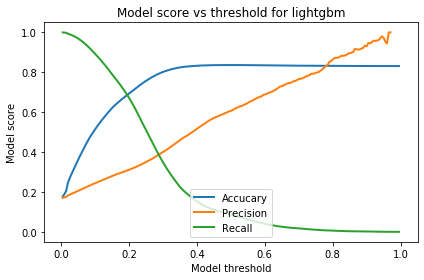

In [91]:

## compute probability of positive case and prediction:
pred_prob = gbm.predict(test_X)

## initialize accuracy, precision and recall:
accuracy, precision, recall = [], [], []

for j in range(len(thresh)):
    pred = pred_prob >= thresh[j]
    conf_matrix = confusion_matrix(test_Y, pred)
    a, p, r = compute_scores(conf_matrix)
    accuracy.append(a)
    precision.append(p)
    recall.append(r)

accuracy, precision, recall = np.asarray(accuracy), np.asarray(precision), np.asarray(recall)
plot_curve( "lightgbm", thresh[1:], "Accucary", accuracy[1:], "Precision", precision[1:], "Recall", recall[1:] )

plt.tight_layout()
plt.show()

In [ ]:
## train-test split: reserve 20% for testing
#from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test =  train_test_split(preX, preY, test_size = 0.2, random_state=0)

In [92]:
#import models:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from xgboost import XGBClassifier

# Logistic Regression
classifier_LR = LogisticRegression()

# K Nearest Neighbors
#classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier(random_state = 0)

## support vector machine:
classifier_SVM = SVC()

## Gradient boosting:
classifier_GB = XGBClassifier(random_state=0)

In [93]:

model_names = ["Logistic Regression", "Random Forest", "Gradient Boosting"]
model_list = [classifier_LR, classifier_RF, classifier_GB]

for i in range(len(model_list)):
    model = model_list[i]
    model.fit(train_X, train_Y)
    pred = model.predict_proba(test_X)[:, 1] > 0.5
    
    conf_matrix = confusion_matrix(test_Y, pred)
    
    a, p, r = compute_scores(conf_matrix)
    print(f"######### For model: ", model_names[i])
    #cv_score = model_selection.cross_val_score(classifier, train_X, train_Y, cv=5)
    print(f"\t Accuracy = {a}, Precision = {p}, Recall = {r}")
    

######### For model:  Logistic Regression
	 Accuracy = 0.8308784330018697, Precision = 0.15584415584415584, Recall = 0.00026670025114273647
######### For model:  Random Forest
	 Accuracy = 0.8135360325974055, Precision = 0.37887350719828555, Recall = 0.1624056362653075
######### For model:  Gradient Boosting
	 Accuracy = 0.831960925161623, Precision = 0.7398097826086957, Recall = 0.008067682597067779
